# Inspired by Sun AI
https://www.youtube.com/@sunairesearch

In [1]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=ad4e7c2bdf2653e2427c33a69c2b4e00b574c5321e17e1a2564314eb5447fa21
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=83725501a4c5761fa24961312fa00c815a81ab040ec090d6c0999ddcd9e0d45c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torchmetrics
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
from glob import glob

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Segmentation Dog Cat Dataset Using U-Net

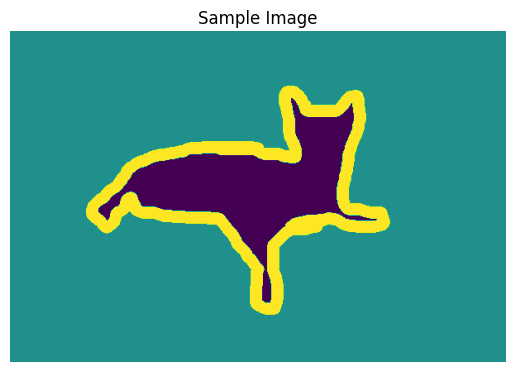

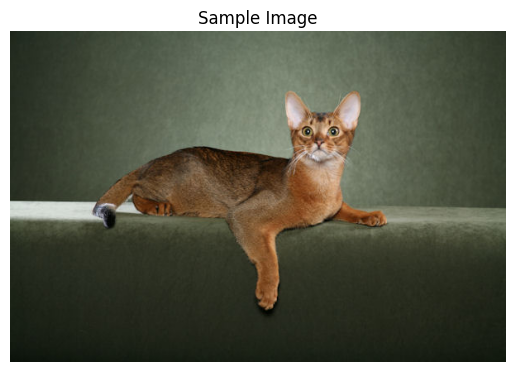

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]] (400, 600) (400, 600, 3)
[1 2 3]


In [ ]:
path = '/kaggle/input/dogcat-dataset/dataset_segmentation/annotations/trimaps/Abyssinian_1.png'
path2 = '/kaggle/input/dogcat-dataset/dataset_segmentation/images/Abyssinian_1.jpg'
img_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(path2)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

plt.imshow(img_mask)
plt.title("Sample Image")
plt.axis("off")  
plt.show()
plt.imshow(img_rgb)
plt.title("Sample Image")
plt.axis("off")  
plt.show()
print(img_mask, img_mask.shape, img.shape)
print(np.unique(img_mask))

# Pixel Annotations: 1: Foreground 2:Background 3: Not classified

/kaggle/input/dogcat-dataset/dataset_segmentation/images/american_pit_bull_terrier_16.jpg


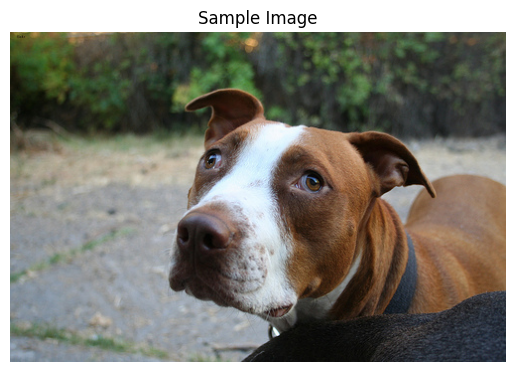

In [5]:
image_paths =glob('/kaggle/input/dogcat-dataset/dataset_segmentation/images/*.jpg')

img = cv2.imread(image_paths[0])  
print(image_paths[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

plt.imshow(img_rgb)
plt.title("Sample Image")
plt.axis("off")  
plt.show()

In [39]:
from torch.utils.data import Dataset

class DogCatDataset(Dataset):
    def __init__(self, root_dir, txt_file, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.txt_file = txt_file
        self.transform = transform
        self.image_paths = []  # Renamed to image_paths for consistency
        
        with open(self.txt_file) as file:
            for line in file:
                self.image_paths.append(line.split(" ")[0])  # More descriptive name
        
    def __len__(self):
        return len(self.image_paths)  # Consistent with the name change
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, "images", "{}.jpg".format(self.image_paths[idx]))  # Consistent name
        mask_path = os.path.join(self.root_dir, "annotations", "trimaps", "{}.png".format(self.image_paths[idx]))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # convert into binary mask
        mask[mask == 2] = 0
        mask[mask == 3] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']

        return transformed_image, transformed_mask

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std  = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


In [11]:
trainsize = 384

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.RGBShift(),
    A.Sharpen(),
    A.CoarseDropout(max_holes=5, max_height=int(384 * 0.1), max_width=int(384 * 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])
    

torch.Size([3, 384, 384])
torch.Size([384, 384])
tensor([0, 1], dtype=torch.uint8)


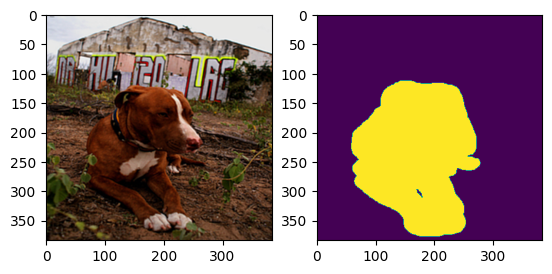

In [15]:
train_dataset =  DogCatDataset("/kaggle/input/dogcat-dataset/dataset_segmentation", "/kaggle/input/dogcat-dataset/dataset_segmentation/annotations/trainval.txt", train_transform)
test_dataset = DogCatDataset("/kaggle/input/dogcat-dataset/dataset_segmentation", "/kaggle/input/dogcat-dataset/dataset_segmentation/annotations/test.txt", test_transform)
image, mask =train_dataset.__getitem__(101)
print(image.shape)
print(mask.shape)
print(mask.unique())

plt.subplot(1,2,1)
plt.imshow(unorm(image).permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [12]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),  # Sử dụng padding=1 để giữ kích thước
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__() 
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        # Encoder
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)

        # Bottleneck
        self.block_neck = unet_block(512, 1024)

        # Decoder
        self.block_up1 = unet_block(1024 + 512, 512)
        self.block_up2 = unet_block(512 + 256, 256)
        self.block_up3 = unet_block(256 + 128, 128)
        self.block_up4 = unet_block(128 + 64, 64)

        # Final output
        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        x1 = self.block_down1(x)
        x = self.downsample(x1)

        x2 = self.block_down2(x)
        x = self.downsample(x2)

        x3 = self.block_down3(x)
        x = self.downsample(x3)

        x4 = self.block_down4(x)
        x = self.downsample(x4)

        # Bottleneck
        x = self.block_neck(x)

        # Decoder 
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)

        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)

        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)

        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)

        # Final output
        x = self.conv_last(x)
        return x


In [ ]:
model = UNet(n_classes=1)
input_tensor = torch.randn(4, 3, trainsize, trainsize)
output = model(input_tensor)
print("Kích thước đầu ra:", output.shape)

Kích thước đầu ra: torch.Size([4, 1, 384, 384])


In [38]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
n_workers = 2  
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

model = UNet(1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 50

dice_fn = torchmetrics.Dice(num_classes=2, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task="binary", average="macro").to(device)

acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 2


In [ ]:
for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze() # -> logit (-inf, +inf)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.sigmoid().round().long() # -> mask (0, 1)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EPOCH {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 48:
        torch.save(model.state_dict(), "/kaggle/working/model_ep_{}.pth".format(ep))

100%|██████████| 230/230 [07:15<00:00,  1.90s/it]


EPOCH 1, train loss = 0.6315548789242039, accuracy = 0.6189430410447327, IoU = 0.1678559442072306, dice = 0.47631694881812386


100%|██████████| 230/230 [07:14<00:00,  1.89s/it]


EPOCH 2, train loss = 0.5259788086880808, accuracy = 0.7475050682606904, IoU = 0.5321824709776632, dice = 0.7375494940125424


100%|██████████| 230/230 [07:15<00:00,  1.89s/it]


EPOCH 3, train loss = 0.49624636536059175, accuracy = 0.7660969208116116, IoU = 0.5499734422434931, dice = 0.7559077801911728


100%|██████████| 230/230 [07:14<00:00,  1.89s/it]


EPOCH 4, train loss = 0.46679984292258386, accuracy = 0.7848428454088128, IoU = 0.5817618972581365, dice = 0.7759306555208952


100%|██████████| 230/230 [07:15<00:00,  1.89s/it]


EPOCH 5, train loss = 0.4245224442171014, accuracy = 0.8105288007984991, IoU = 0.6231558576874111, dice = 0.8027253933574843


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 6, train loss = 0.3844064547963764, accuracy = 0.8303780107394508, IoU = 0.6576636184816775, dice = 0.8237455002639604


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 7, train loss = 0.3596651208789452, accuracy = 0.8441418082817741, IoU = 0.6796831460102745, dice = 0.837578287591105


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 8, train loss = 0.3411049978888553, accuracy = 0.8528855367847111, IoU = 0.6966328799724579, dice = 0.8470649716646775


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 9, train loss = 0.31897767568412033, accuracy = 0.8625156830186429, IoU = 0.7144756630710933, dice = 0.8573948292628578


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 10, train loss = 0.3016095281295154, accuracy = 0.8721521942511848, IoU = 0.730569138734237, dice = 0.8670508978159531


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 11, train loss = 0.2950518519334171, accuracy = 0.8747823010320249, IoU = 0.7360929756060891, dice = 0.8700147087159364


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 12, train loss = 0.28471126070489056, accuracy = 0.8802778236244035, IoU = 0.7464639793271604, dice = 0.8757302061371182


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 13, train loss = 0.27825054182954456, accuracy = 0.8829057903393455, IoU = 0.7511716386546259, dice = 0.8784794480904289


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 14, train loss = 0.2715701901394388, accuracy = 0.8863107393617216, IoU = 0.7572805536829907, dice = 0.8818329272062883


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 15, train loss = 0.2629791807869206, accuracy = 0.8904172671877819, IoU = 0.7652340645375459, dice = 0.8861869257429372


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 16, train loss = 0.25688570692487384, accuracy = 0.8931610055591749, IoU = 0.7702394304068192, dice = 0.8890175762383834


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 17, train loss = 0.24709826694882434, accuracy = 0.897337408946908, IoU = 0.7781542119772538, dice = 0.8933646274649578


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 18, train loss = 0.24939290524824806, accuracy = 0.8960230928400289, IoU = 0.7756402575451394, dice = 0.8918988676174827


100%|██████████| 230/230 [07:15<00:00,  1.89s/it]


EPOCH 19, train loss = 0.2428233429789543, accuracy = 0.8995838429616845, IoU = 0.7831078451612722, dice = 0.8959125153396441


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 20, train loss = 0.23637750174688257, accuracy = 0.9025311065756756, IoU = 0.7887701317020085, dice = 0.8987275263537531


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 21, train loss = 0.23044582249029824, accuracy = 0.9047795319038888, IoU = 0.792438853305319, dice = 0.9010423953118532


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 22, train loss = 0.22648443203905355, accuracy = 0.9074846995913464, IoU = 0.7977912501148555, dice = 0.903782598350359


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 23, train loss = 0.22171167834945346, accuracy = 0.9091732841470967, IoU = 0.801542998396832, dice = 0.9056689669256625


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 24, train loss = 0.21392855508171993, accuracy = 0.912460363170375, IoU = 0.8078805438850237, dice = 0.9090851625670557


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 25, train loss = 0.20940966120232707, accuracy = 0.9137334201646887, IoU = 0.8107069795546324, dice = 0.9104614262995513


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 26, train loss = 0.20609643264957098, accuracy = 0.9156936969446099, IoU = 0.8142921126407126, dice = 0.9123550713062286


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 27, train loss = 0.20833114764612654, accuracy = 0.9149521161680636, IoU = 0.812886613348256, dice = 0.9116276860237121


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 28, train loss = 0.20106810023603233, accuracy = 0.9179548895877341, IoU = 0.8188432359177134, dice = 0.9147872517938199


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 29, train loss = 0.19776570473028265, accuracy = 0.9193145288073499, IoU = 0.8211821999238885, dice = 0.916088828055755


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 30, train loss = 0.19357608200415322, accuracy = 0.9213259253812873, IoU = 0.8256751078626384, dice = 0.9182559793410094


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 31, train loss = 0.1919694473238095, accuracy = 0.9216080844402313, IoU = 0.8264219535433728, dice = 0.9185229651305986


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 32, train loss = 0.18192810432418532, accuracy = 0.9253903106502864, IoU = 0.8341523613618768, dice = 0.9225739834101304


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 33, train loss = 0.18130481223697248, accuracy = 0.926321563254232, IoU = 0.8360774296781291, dice = 0.9235607756220776


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 34, train loss = 0.17337218092187592, accuracy = 0.9298586619936902, IoU = 0.8429136017094487, dice = 0.927142723487771


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 35, train loss = 0.1723077241493308, accuracy = 0.929956767351731, IoU = 0.8431372974229896, dice = 0.9272528350353241


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 36, train loss = 0.17394854497650394, accuracy = 0.9298486017662546, IoU = 0.8431103110313416, dice = 0.927142832590186


100%|██████████| 230/230 [07:16<00:00,  1.90s/it]


EPOCH 37, train loss = 0.16668779182693233, accuracy = 0.9323394757250081, IoU = 0.8482912701109181, dice = 0.929770453079887


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 38, train loss = 0.16466856229564417, accuracy = 0.9329363441985586, IoU = 0.8491306203862895, dice = 0.9302751603333846


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 39, train loss = 0.15875554800681446, accuracy = 0.9355704781801805, IoU = 0.8550284517847974, dice = 0.9331126860950304


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 40, train loss = 0.15141717153398887, accuracy = 0.9387829067914383, IoU = 0.8615255075952281, dice = 0.9363813612772071


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 41, train loss = 0.15080707144478092, accuracy = 0.9390021241229514, IoU = 0.861851676132368, dice = 0.9365975170031838


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 42, train loss = 0.1426489484374938, accuracy = 0.9422412859356921, IoU = 0.8687898793946142, dice = 0.9399871608485346


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 43, train loss = 0.14175629068327986, accuracy = 0.9425948174103447, IoU = 0.8693798479826554, dice = 0.9403690172278363


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 44, train loss = 0.13945776395823645, accuracy = 0.9437621163285297, IoU = 0.8718799298224242, dice = 0.9415322692497917


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 45, train loss = 0.13832112472990285, accuracy = 0.9444492949091869, IoU = 0.8736111420652141, dice = 0.9423310440519582


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 46, train loss = 0.13116343147728754, accuracy = 0.9470256955727286, IoU = 0.8788712369359057, dice = 0.9449325170205987


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 47, train loss = 0.13055049022254736, accuracy = 0.9474755543729533, IoU = 0.8799230420071146, dice = 0.9454423956249072


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 48, train loss = 0.12700898741250452, accuracy = 0.9486604387345521, IoU = 0.8823837979980137, dice = 0.9466072307980579


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 49, train loss = 0.12433535618626552, accuracy = 0.949804638520531, IoU = 0.8848141988982325, dice = 0.9478735249975453


100%|██████████| 230/230 [07:17<00:00,  1.90s/it]


EPOCH 50, train loss = 0.11673704233506452, accuracy = 0.9530684142009072, IoU = 0.8922211045804231, dice = 0.9513191192046456


In [27]:
model.eval()
test_iou_meter = AverageMeter()
test_dice_meter = AverageMeter()
with torch.no_grad():
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        y_hat = y_hat.squeeze()
        y_hat_mask = y_hat.sigmoid().round().long()
        dice_score = dice_fn(y_hat_mask, y.long())
        iou_score = iou_fn(y_hat_mask, y.long())
        test_dice_meter.update(dice_score.item(), n)
        test_iou_meter.update(iou_score.item(), n)
print("TEST: IoU = {}, dice = {}".format(test_iou_meter.avg, test_dice_meter.avg))

100%|██████████| 230/230 [02:29<00:00,  1.54it/s]

TEST: IoU = 0.8486125923918586, dice = 0.9280859182562611


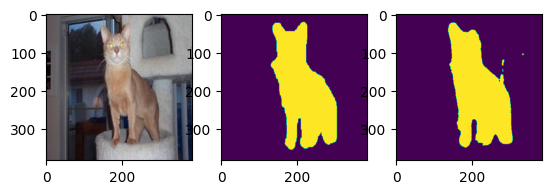

In [29]:
import random

model.eval()
idx = random.randint(0, 100)
with torch.no_grad():
    x, y = test_dataset[idx]
    # print(x.shape, y.shape) (C, H, W) -> (1, C, H, W) -> model
    x = x.to(device).float().unsqueeze(0)
    y_hat = model(x).squeeze() #(1, 1, H, W) -> (H, W)
    y_hat_mask = y_hat.sigmoid().round().long()
    # x, y, y_hat_mask
    
    plt.subplot(1, 3, 1)
    plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0)) # x (GPU) -> x(CPU)
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_mask.cpu())

# Segmentation VOC Dataset Using U-Net 

# https://github.com/albumentations-team/autoalbument/blob/master/examples/pascal_voc/dataset.py


In [35]:
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [36]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.RGBShift(),
    A.Sharpen(),
    A.CoarseDropout(max_holes=5, max_height=int(384 * 0.1), max_width=int(384 * 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])
    

In [37]:
train_dataset =  PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_transform)

Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


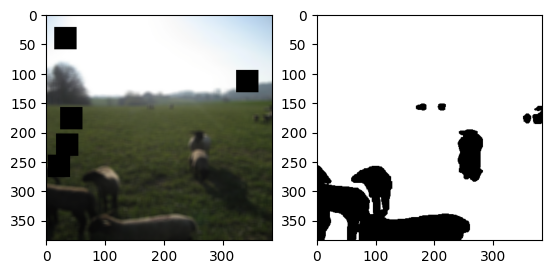

In [17]:
image, mask = train_dataset.__getitem__(1000)

plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0)) 
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 0], cmap='gray')

plt.show()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 4
n_workers = 2
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

model = UNet(21).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 15

dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()


for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).argmax(dim=-1).long()  # Fix here
        y_hat = model(x)  # (B, C, H, W)
        loss = criterion(y_hat, y)  # (B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1)  # (B, C, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y)
            iou_score = iou_fn(y_hat_mask, y)
            accuracy = accuracy_function(y_hat_mask, y)

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EPOCH {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))

100%|██████████| 366/366 [03:36<00:00,  1.69it/s]


EPOCH 1, train loss = 1.4502661528645968, accuracy = 0.7278723905288902, IoU = 0.11603101362637117, dice = 0.1321629773408093


100%|██████████| 366/366 [03:47<00:00,  1.61it/s]


EPOCH 2, train loss = 1.2415513380791972, accuracy = 0.7490374425558445, IoU = 0.12898229692599486, dice = 0.1467010578944709


100%|██████████| 366/366 [03:56<00:00,  1.55it/s]


EPOCH 3, train loss = 1.2305972931163558, accuracy = 0.7490374418230005, IoU = 0.12996610586882615, dice = 0.1477963725522242


100%|██████████| 366/366 [03:56<00:00,  1.55it/s]


EPOCH 4, train loss = 1.2142401858757101, accuracy = 0.7490374419044276, IoU = 0.12866240561700584, dice = 0.1463180896240831


100%|██████████| 366/366 [03:56<00:00,  1.55it/s]


EPOCH 5, train loss = 1.206464469514258, accuracy = 0.7490374419044276, IoU = 0.13070729977446174, dice = 0.14864902137244335


100%|██████████| 366/366 [03:56<00:00,  1.55it/s]


EPOCH 6, train loss = 1.2013197740733297, accuracy = 0.7490374432072613, IoU = 0.1294380676388089, dice = 0.14707607364719683


100%|██████████| 366/366 [03:48<00:00,  1.60it/s]


EPOCH 7, train loss = 1.1988895783821742, accuracy = 0.7490374430444071, IoU = 0.12906809614289327, dice = 0.14673977359477938


100%|██████████| 366/366 [03:45<00:00,  1.62it/s]


EPOCH 8, train loss = 1.1882775401482817, accuracy = 0.7490374441843867, IoU = 0.12921580515516912, dice = 0.14697061350843946


100%|██████████| 366/366 [03:45<00:00,  1.62it/s]


EPOCH 9, train loss = 1.1786528315211906, accuracy = 0.7490374439401053, IoU = 0.1298619059469205, dice = 0.1474335026708457


100%|██████████| 366/366 [03:45<00:00,  1.62it/s]


EPOCH 10, train loss = 1.1750460367222302, accuracy = 0.74903744296298, IoU = 0.12986608093879262, dice = 0.14760061241482778


100%|██████████| 366/366 [03:45<00:00,  1.63it/s]


EPOCH 11, train loss = 1.1661161969268257, accuracy = 0.7490374432072613, IoU = 0.12967592031985034, dice = 0.14746923176724402


100%|██████████| 366/366 [03:44<00:00,  1.63it/s]


EPOCH 12, train loss = 1.1576623298594209, accuracy = 0.7490374428815529, IoU = 0.13037916750245082, dice = 0.1480409475908579


100%|██████████| 366/366 [03:44<00:00,  1.63it/s]


EPOCH 13, train loss = 1.1511127628752442, accuracy = 0.7490374428001257, IoU = 0.12840185761248155, dice = 0.146172422284637


100%|██████████| 366/366 [03:44<00:00,  1.63it/s]


EPOCH 14, train loss = 1.1321639533414216, accuracy = 0.7488899883188185, IoU = 0.12881188871227, dice = 0.14670676066250096


100%|██████████| 366/366 [03:44<00:00,  1.63it/s]

EPOCH 15, train loss = 1.1236669195642888, accuracy = 0.7488757120292695, IoU = 0.1287279152133263, dice = 0.14653336376847464


Như đã quan sát, U-Net đôi khi có thể dẫn đến hiện tượng underfitting khi áp dụng cho các bộ dữ liệu lớn trong các nhiệm vụ phân đoạn. Để giải quyết vấn đề này, chúng tôi đề xuất nâng cao mô hình bằng cách tích hợp một ResNet đã được huấn luyện trước vào khối encoder. Điều này cho phép mô hình tận dụng các biểu diễn đặc trưng đã được học trước, giúp nó nắm bắt các mẫu phức tạp hơn và cải thiện hiệu suất trên các bộ dữ liệu lớn.

In [8]:
!pip install timm

In [9]:
# https://huggingface.co/docs/timm/feature_extraction
import timm
backbone = timm.create_model("resnet101", features_only=True, pretrained=True)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
x = torch.rand(3,3,256,256)
features = backbone(x)
for feature in features:
    print(feature.shape)

print("________")
x1, x2, x3, x4, x5 = backbone(x)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([3, 64, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 1024, 16, 16])
torch.Size([3, 2048, 8, 8])
________
torch.Size([3, 64, 128, 128])
torch.Size([3, 256, 64, 64])
torch.Size([3, 512, 32, 32])
torch.Size([3, 1024, 16, 16])
torch.Size([3, 2048, 8, 8])


In [10]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),  # Sử dụng padding=1 để giữ kích thước
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

class ResUNet(nn.Module):
    def __init__(self, n_classes):
        super(ResUNet, self).__init__()

        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet101", features_only=True, pretrained=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        
        self.block_neck = unet_block(2048, 1024)

        self.block_up1 = unet_block(1024+1024, 512)
        self.block_up2 = unet_block(512+512, 256)
        self.block_up3 = unet_block(256+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x)
        
        x = self.block_neck(x5)
        
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        
        x = self.conv_cls(x)  # B n_class H/2 W/2
        x = self.upsample(x)
        return x
    
# model = ResUNet(21)
# x = torch.rand(3,3,256,256)
# y = model(x)
# print(y.shape)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8
n_workers = 2
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

model = ResUNet(21).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 60

dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()


for ep in range(1, 1+n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).argmax(dim=-1).long()  # Fix here
        y_hat = model(x)  # (B, C, H, W)
        loss = criterion(y_hat, y)  # (B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1)  # (B, C, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y)
            iou_score = iou_fn(y_hat_mask, y)
            accuracy = accuracy_function(y_hat_mask, y)

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EPOCH {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))
    if ep >= 59:
        torch.save(model.state_dict(), "/kaggle/working/model_res_ep_{}.pth".format(ep))
    

100%|██████████| 183/183 [02:08<00:00,  1.43it/s]


EPOCH 1, train loss = 1.2318032002839885, accuracy = 0.7374614444586749, IoU = 0.08104865632816396, dice = 0.0924824278176981


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EPOCH 2, train loss = 0.9966957891573671, accuracy = 0.7539123264166827, IoU = 0.08885477646126773, dice = 0.10310541728480918


100%|██████████| 183/183 [02:08<00:00,  1.43it/s]


EPOCH 3, train loss = 0.9046485893061904, accuracy = 0.7710749308268229, IoU = 0.11550719258400911, dice = 0.1387530499713017


100%|██████████| 183/183 [02:09<00:00,  1.42it/s]


EPOCH 4, train loss = 0.791519465016537, accuracy = 0.7967276859804581, IoU = 0.15672343883846626, dice = 0.1887221906761654


100%|██████████| 183/183 [02:11<00:00,  1.40it/s]


EPOCH 5, train loss = 0.7177713927024049, accuracy = 0.805829449429538, IoU = 0.168868121635067, dice = 0.20320807234511348


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EPOCH 6, train loss = 0.652237256205147, accuracy = 0.8143034241889995, IoU = 0.18820591812413898, dice = 0.2262306460510186


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 7, train loss = 0.6143166604426389, accuracy = 0.8228517751224705, IoU = 0.1991720327629092, dice = 0.2401057034934479


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EPOCH 8, train loss = 0.5689969868933569, accuracy = 0.8350208991212271, IoU = 0.21899454267135735, dice = 0.2634505665367418


100%|██████████| 183/183 [02:11<00:00,  1.40it/s]


EPOCH 9, train loss = 0.49870768897846096, accuracy = 0.8519015911498357, IoU = 0.25280000566621946, dice = 0.3031359106465116


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 10, train loss = 0.4562517267758729, accuracy = 0.8614384385405994, IoU = 0.2822302842889327, dice = 0.33548622712737225


100%|██████████| 183/183 [02:10<00:00,  1.41it/s]


EPOCH 11, train loss = 0.42610143035487397, accuracy = 0.8722707717145075, IoU = 0.2964247882040472, dice = 0.35027764094331876


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EPOCH 12, train loss = 0.40945942431199744, accuracy = 0.8774338081234792, IoU = 0.31638120766220196, dice = 0.3721047154541224


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EPOCH 13, train loss = 0.3633937746937809, accuracy = 0.8900711184642354, IoU = 0.343762059599324, dice = 0.4009317961709747


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EPOCH 14, train loss = 0.3461966504816149, accuracy = 0.8965438571784015, IoU = 0.3583438565822247, dice = 0.41641549228644764


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EPOCH 15, train loss = 0.3204533970746838, accuracy = 0.9017879611156026, IoU = 0.3793954724659685, dice = 0.43859805109722366


100%|██████████| 183/183 [02:10<00:00,  1.41it/s]


EPOCH 16, train loss = 0.3008770297785274, accuracy = 0.9072168173034334, IoU = 0.40148168655692557, dice = 0.46087017614659065


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 17, train loss = 0.29205703621353607, accuracy = 0.9083231628918257, IoU = 0.3874577074591579, dice = 0.4443441514597564


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EPOCH 18, train loss = 0.2721517469957878, accuracy = 0.9147831129897488, IoU = 0.4342372955683151, dice = 0.49468835610183864


100%|██████████| 183/183 [02:07<00:00,  1.44it/s]


EPOCH 19, train loss = 0.2632057678992631, accuracy = 0.9183173883156698, IoU = 0.42805436546685266, dice = 0.4873900480283414


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 20, train loss = 0.24375002448513208, accuracy = 0.92244271241902, IoU = 0.4413225445591035, dice = 0.49922393775377116


100%|██████████| 183/183 [02:10<00:00,  1.41it/s]


EPOCH 21, train loss = 0.23505439894284055, accuracy = 0.9270045275245208, IoU = 0.4606136663363931, dice = 0.5208246657431451


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EPOCH 22, train loss = 0.2255582855861695, accuracy = 0.9270531701259925, IoU = 0.4675805589866117, dice = 0.5277798203496985


100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


EPOCH 23, train loss = 0.2294429849650039, accuracy = 0.9278496184635684, IoU = 0.47772326202340465, dice = 0.5383780500927909


100%|██████████| 183/183 [02:15<00:00,  1.36it/s]


EPOCH 24, train loss = 0.20545978897093423, accuracy = 0.9330469663025903, IoU = 0.4875168972979478, dice = 0.5470252387184914


100%|██████████| 183/183 [02:10<00:00,  1.41it/s]


EPOCH 25, train loss = 0.2014186146155081, accuracy = 0.9348115452000352, IoU = 0.5071575511348704, dice = 0.568719577105319


100%|██████████| 183/183 [02:11<00:00,  1.40it/s]


EPOCH 26, train loss = 0.19847411426201544, accuracy = 0.9341613477696487, IoU = 0.5137243594953923, dice = 0.5763163591017488


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 27, train loss = 0.18580036875003023, accuracy = 0.9390693101726595, IoU = 0.5248320511455744, dice = 0.5886316757058837


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 28, train loss = 0.18448776670329559, accuracy = 0.9391643857695365, IoU = 0.5185739134178787, dice = 0.5801826153622299


100%|██████████| 183/183 [02:08<00:00,  1.43it/s]


EPOCH 29, train loss = 0.17603568443672254, accuracy = 0.9415654979768346, IoU = 0.5336305039827941, dice = 0.5961123817279691


100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


EPOCH 30, train loss = 0.186486474681096, accuracy = 0.9384909040940915, IoU = 0.5318212702951796, dice = 0.5945931985730031


100%|██████████| 183/183 [02:11<00:00,  1.39it/s]


EPOCH 31, train loss = 0.16960151025343462, accuracy = 0.9439655158037696, IoU = 0.5461220140339899, dice = 0.609953351522404


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 32, train loss = 0.1659845112532866, accuracy = 0.9457818224130432, IoU = 0.5538759658245441, dice = 0.6160413964850003


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EPOCH 33, train loss = 0.16788909099792523, accuracy = 0.9437893205653123, IoU = 0.5637443371809245, dice = 0.6276174702279554


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EPOCH 34, train loss = 0.16958021738978682, accuracy = 0.9452443878507354, IoU = 0.5637009335997326, dice = 0.6272274679173537


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 35, train loss = 0.16765843437669056, accuracy = 0.94473391673604, IoU = 0.5614520946487052, dice = 0.6236358552031178


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EPOCH 36, train loss = 0.16113122446778042, accuracy = 0.9469059803446785, IoU = 0.5775698708380507, dice = 0.6419962730889763


100%|██████████| 183/183 [02:07<00:00,  1.44it/s]


EPOCH 37, train loss = 0.15058651965498274, accuracy = 0.9502152614906186, IoU = 0.5800591388035342, dice = 0.6439963274640463


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 38, train loss = 0.1397771110829434, accuracy = 0.9521604861066642, IoU = 0.5977983051310471, dice = 0.6615175241655339


100%|██████████| 183/183 [02:13<00:00,  1.37it/s]


EPOCH 39, train loss = 0.1425617658456818, accuracy = 0.9520702362060547, IoU = 0.5985219884114187, dice = 0.6616825772439195


100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


EPOCH 40, train loss = 0.14065601705201988, accuracy = 0.952025950280695, IoU = 0.6003949922290656, dice = 0.6647354486535807


100%|██████████| 183/183 [02:12<00:00,  1.38it/s]


EPOCH 41, train loss = 0.1357523684333908, accuracy = 0.9534044630540525, IoU = 0.6090140762876292, dice = 0.6732583933514975


100%|██████████| 183/183 [02:11<00:00,  1.40it/s]


EPOCH 42, train loss = 0.12709564913084598, accuracy = 0.9559636663218014, IoU = 0.6204773386319479, dice = 0.6828759221431336


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


EPOCH 43, train loss = 0.14016569395615755, accuracy = 0.9528612543324955, IoU = 0.6186672686879101, dice = 0.6832374956438451


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


EPOCH 44, train loss = 0.12547522752744253, accuracy = 0.9564941385404659, IoU = 0.6226215014040796, dice = 0.6851565497494786


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


EPOCH 45, train loss = 0.13521353381334758, accuracy = 0.9541364575995773, IoU = 0.6069913988556367, dice = 0.6700144441075664


100%|██████████| 183/183 [02:18<00:00,  1.32it/s]


EPOCH 46, train loss = 0.12496578308646797, accuracy = 0.9564792028541773, IoU = 0.6430768022120325, dice = 0.7081164961955586


100%|██████████| 183/183 [02:17<00:00,  1.33it/s]


EPOCH 47, train loss = 0.1267817619516224, accuracy = 0.956304091573413, IoU = 0.6256297365889523, dice = 0.6887630732333074


100%|██████████| 183/183 [02:15<00:00,  1.35it/s]


EPOCH 48, train loss = 0.12288698421719947, accuracy = 0.9570558891921747, IoU = 0.6492134625794458, dice = 0.7132649353293122


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


EPOCH 49, train loss = 0.12220927541617488, accuracy = 0.9572586830847901, IoU = 0.6405166573211795, dice = 0.7038711807766899


100%|██████████| 183/183 [02:16<00:00,  1.34it/s]


EPOCH 50, train loss = 0.12502723048782088, accuracy = 0.9571470562877551, IoU = 0.6239250167145756, dice = 0.686570632490304


100%|██████████| 183/183 [02:14<00:00,  1.36it/s]


EPOCH 51, train loss = 0.1157400319403638, accuracy = 0.9594237113910946, IoU = 0.6606290513049058, dice = 0.7244557116201015


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EPOCH 52, train loss = 0.11933059503879052, accuracy = 0.9584526416382503, IoU = 0.644033731658602, dice = 0.7086080324128677


100%|██████████| 183/183 [02:10<00:00,  1.41it/s]


EPOCH 53, train loss = 0.11436380965055012, accuracy = 0.9598512910102885, IoU = 0.6659444778994784, dice = 0.729873354317712


100%|██████████| 183/183 [02:10<00:00,  1.40it/s]


EPOCH 54, train loss = 0.11246477861384876, accuracy = 0.9599152445141735, IoU = 0.6397160151617123, dice = 0.7026039308211842


100%|██████████| 183/183 [02:09<00:00,  1.41it/s]


EPOCH 55, train loss = 0.1079126069413834, accuracy = 0.961424530529585, IoU = 0.6612222891687696, dice = 0.7244084576765696


100%|██████████| 183/183 [02:08<00:00,  1.42it/s]


EPOCH 56, train loss = 0.11026171037082463, accuracy = 0.9610944549894073, IoU = 0.6735052650417787, dice = 0.7360082993416187


100%|██████████| 183/183 [02:07<00:00,  1.43it/s]


EPOCH 57, train loss = 0.136449161387695, accuracy = 0.9548027580553066, IoU = 0.617611378268466, dice = 0.6811206169792863


100%|██████████| 183/183 [02:08<00:00,  1.43it/s]


EPOCH 58, train loss = 0.11526579743688875, accuracy = 0.9591429976166271, IoU = 0.6549614967544222, dice = 0.7170833113089286


100%|██████████| 183/183 [02:06<00:00,  1.44it/s]


EPOCH 59, train loss = 0.10704462726910909, accuracy = 0.9618324946836044, IoU = 0.6653883885490438, dice = 0.7277125097363373


100%|██████████| 183/183 [02:09<00:00,  1.42it/s]


EPOCH 60, train loss = 0.10926508925895874, accuracy = 0.9613705619436795, IoU = 0.6651795537419658, dice = 0.7262163787591652


background
motorbike
person


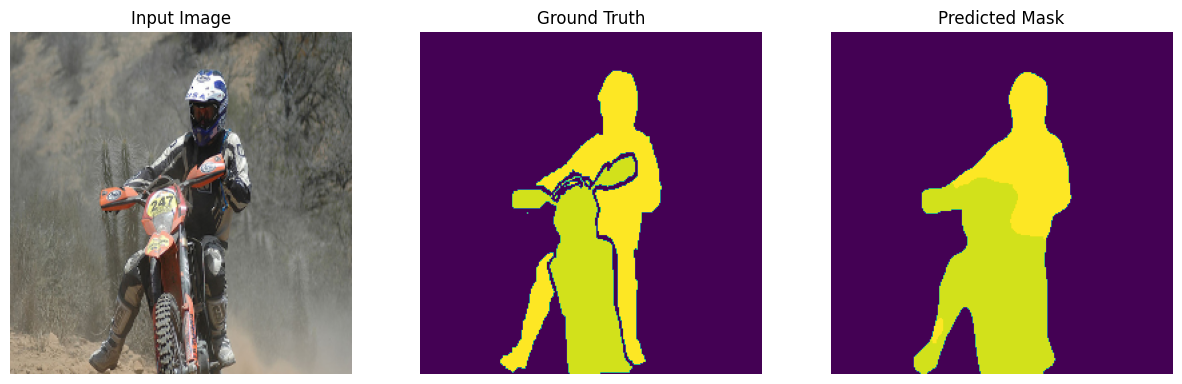

background
bottle


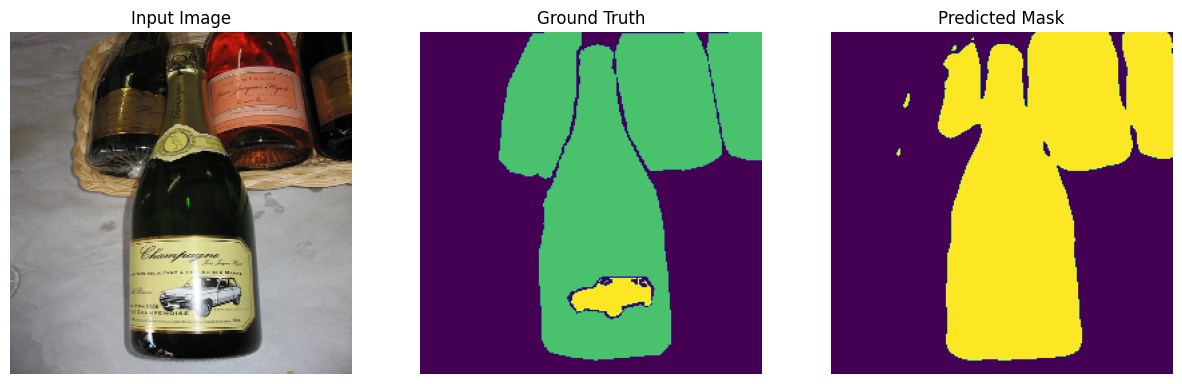

background
car
person


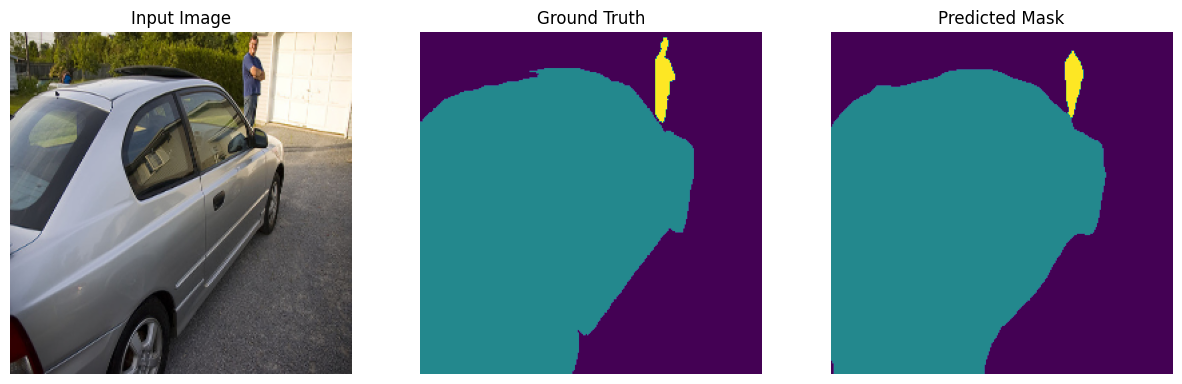

background
bird
dog


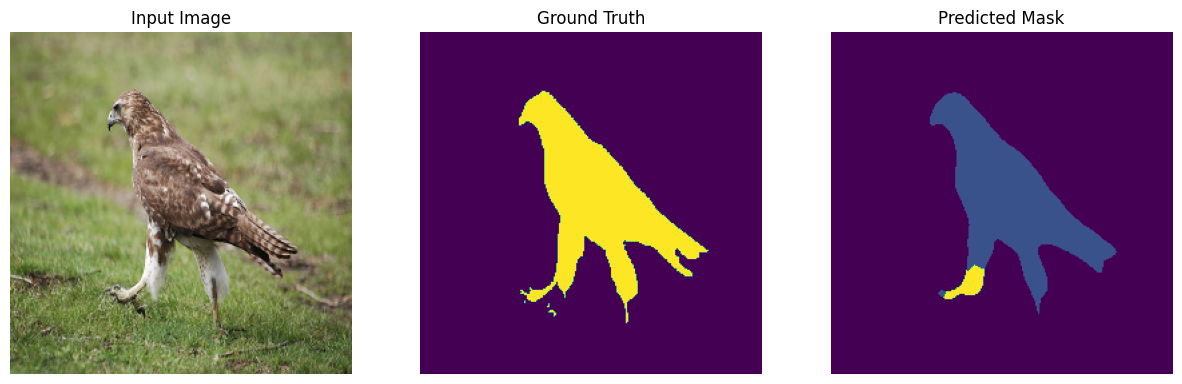

background
chair
person
sofa


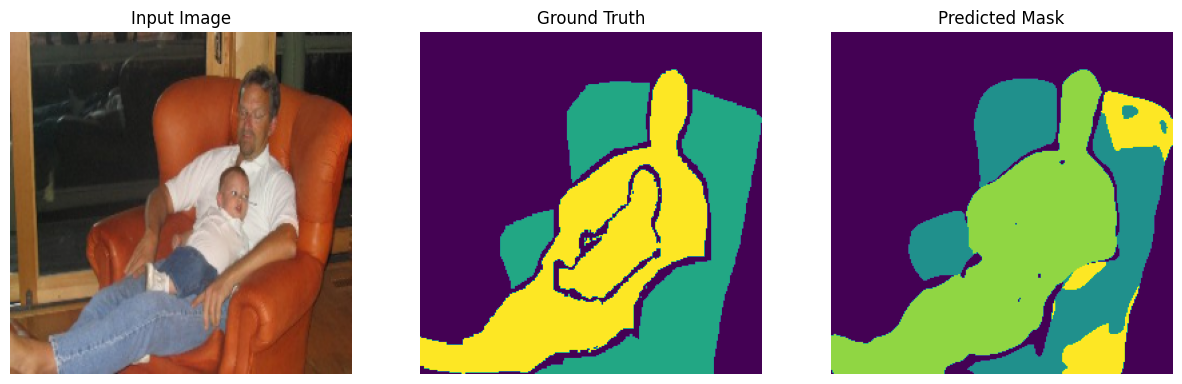

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

for i in range(5):
    # Randomly select an image and its ground truth from the test dataset
    id = random.randint(0, len(test_dataset) - 1)
    
    with torch.no_grad():
        model.eval()
        x, y = test_dataset.__getitem__(id)
        x = x.unsqueeze(0).to(device)  # Add batch dimension
        y_predict = model(x).argmax(dim=1).squeeze().cpu().numpy()  # Get predicted mask (2D array)
        
        # Print class labels for the predicted mask (if any)
        for class_id in np.unique(y_predict):
            print(VOC_CLASSES[class_id])

    # Convert the input image to a numpy array for visualization (if it's a tensor)
    x = x.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for RGB
    
    # Convert ground truth (if y is one-hot encoded, apply argmax to get the class labels)
    ground_truth = y.squeeze().cpu().numpy()  # (H, W, 21) -> (H, W)
    ground_truth = np.argmax(ground_truth, axis=-1)  # Apply argmax to reduce to (H, W)
    
    # Define the mean and std values used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Unnormalize: multiply by std and add mean for each channel
    unnormalized_image = x * std + mean  # Unnormalize the image

    # Clip values to [0, 1] to make sure they are within the valid range for displaying
    unnormalized_image = np.clip(unnormalized_image, 0, 1)
    
    # Plot the input image, ground truth, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Input Image (unnormalized)
    axes[0].imshow(unnormalized_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Ground Truth (2D array with class labels)
    axes[1].imshow(ground_truth)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")
    
    # Predicted Mask (2D array with class labels)
    axes[2].imshow(y_predict)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()


/tmp/ipykernel_30/968291896.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("/kaggle/working/model_res_ep_60.pth"))


background
bus
train


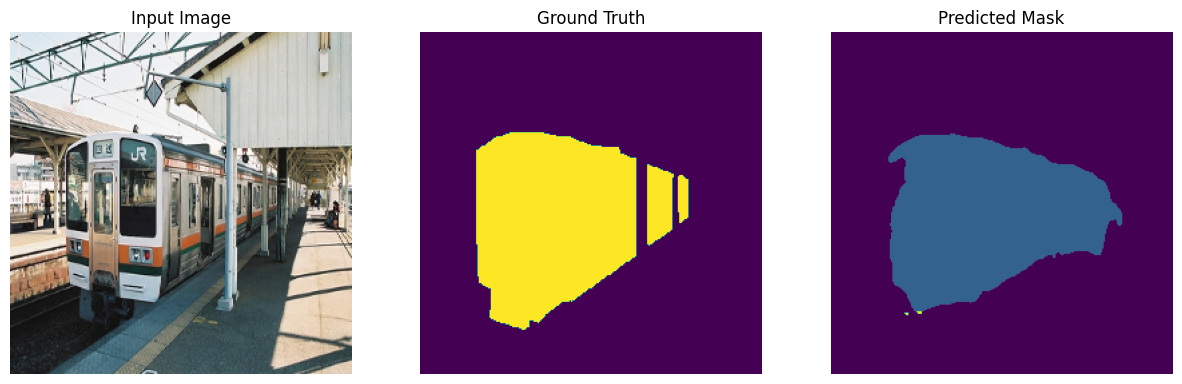

background
bus
car
dog
horse
motorbike
sheep
train


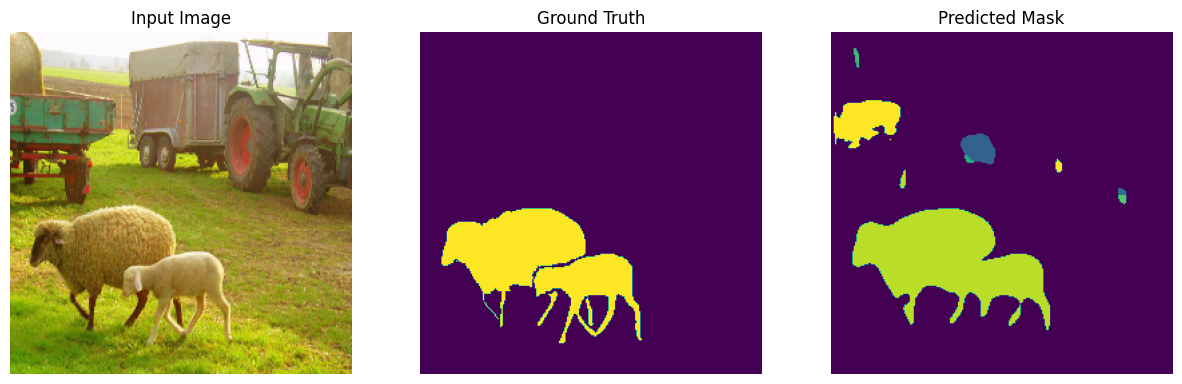

background
bicycle
motorbike


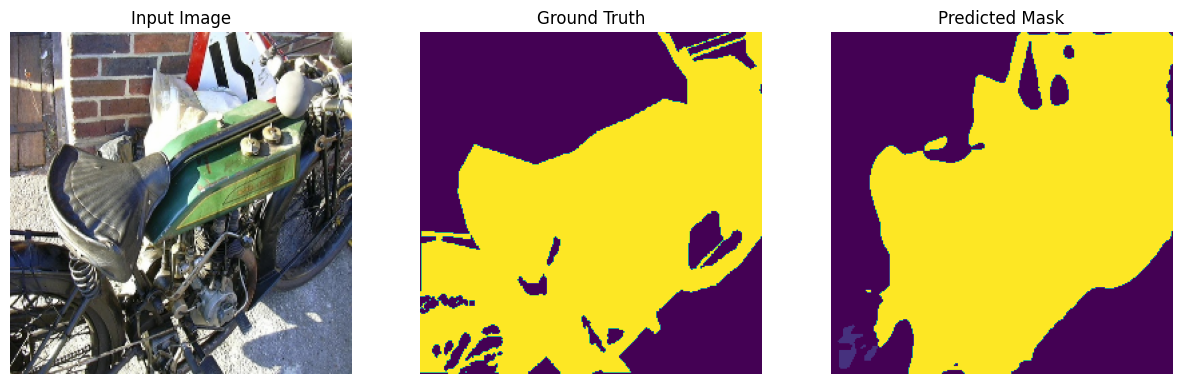

background
bottle
person


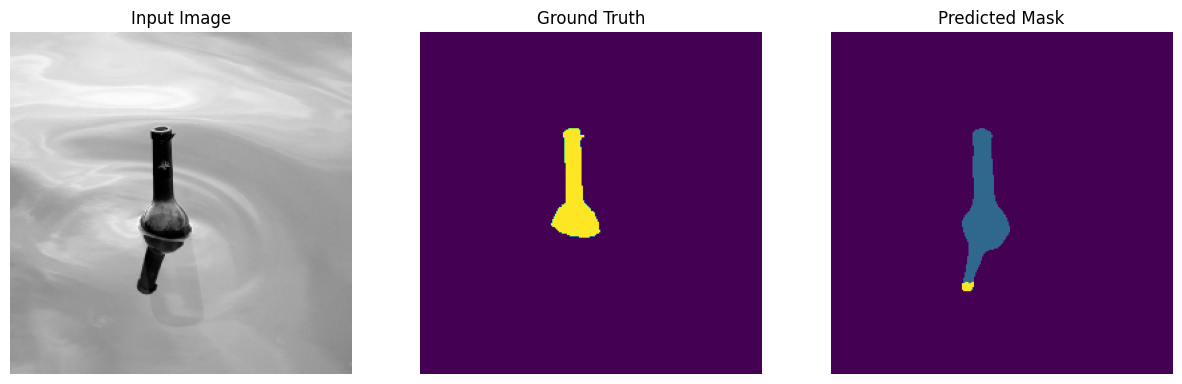

background
bird


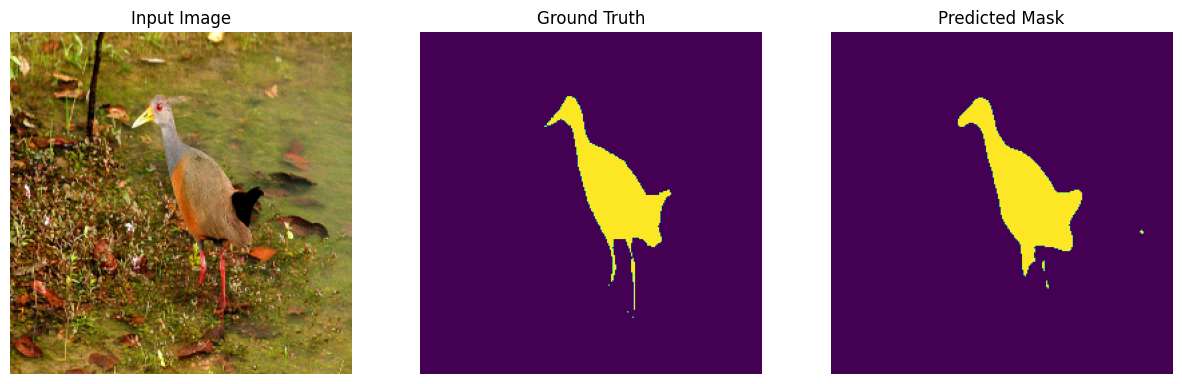

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model2 = ResUNet(21).to(device)
model2.load_state_dict(torch.load("/kaggle/working/model_res_ep_60.pth"))
model2.eval()

# Visualizing predictions on test data
for i in range(5):
    # Randomly select an image and its ground truth from the test dataset
    id = random.randint(0, len(test_dataset) - 1)

    with torch.no_grad():
        x, y = test_dataset.__getitem__(id)
        x = x.unsqueeze(0).to(device)  # Add batch dimension
        y_predict = model2(x).argmax(dim=1).squeeze().cpu().numpy()  # Get predicted mask (2D array)

        for class_id in np.unique(y_predict):
            print(VOC_CLASSES[class_id])

    # Convert the input image to a numpy array for visualization (if it's a tensor)
    x = x.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C) for RGB
    
    # Convert ground truth (if y is one-hot encoded, apply argmax to get the class labels)
    ground_truth = y.squeeze().cpu().numpy()  # (H, W, 21) -> (H, W)
    ground_truth = np.argmax(ground_truth, axis=-1)  # Apply argmax to reduce to (H, W)

    # Define the mean and std values used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Unnormalize: multiply by std and add mean for each channel
    unnormalized_image = x * std + mean  # Unnormalize the image

    # Clip values to [0, 1] to make sure they are within the valid range for displaying
    unnormalized_image = np.clip(unnormalized_image, 0, 1)

    # Plot the input image, ground truth, and predicted mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Input Image (unnormalized)
    axes[0].imshow(unnormalized_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Ground Truth (2D array with class labels)
    axes[1].imshow(ground_truth)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # Predicted Mask (2D array with class labels)
    axes[2].imshow(y_predict)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

/tmp/ipykernel_30/771000374.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model_res_ep_60.pth"))


background
cat


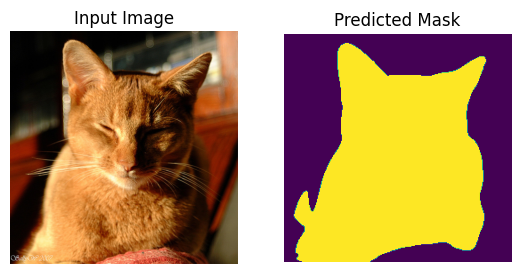

In [61]:
from PIL import Image
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet(21).to(device)
model.load_state_dict(torch.load("/kaggle/working/model_res_ep_60.pth"))
model.eval()

image_path = "/kaggle/input/dogcat-dataset/dataset_segmentation/images/Abyssinian_112.jpg"  
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),  # Chuyển ảnh sang tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

input_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension và đưa vào device

with torch.no_grad():
    output = model(input_tensor)  
    predicted_mask = output.argmax(dim=1).squeeze().cpu().numpy()  # Chọn lớp có xác suất cao nhất
    for class_id in np.unique(predicted_mask):
        print(VOC_CLASSES[class_id])

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(np.array(image))
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask)
plt.title("Predicted Mask")
plt.axis('off')

plt.show()